# Набор данных
Оценить какие признаки влияют на цены жилья в Перте

Набор данных представляет собой набор различных признаков домов.

Источник данных: https://www.kaggle.com/datasets/syuzai/perth-house-prices

# Import библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Набор данных

Данные предварительно были обработаны в [лабораторной по регрессии](https://colab.research.google.com/drive/1rxaHmu70gyQJmQcrxfzDXv6iMVqIzWBq?usp=sharing)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/datasets/лаб2/house_price_clean', delimiter=',')
df

,address,suburb,price,bedrooms,bathrooms,garage,land_area,floor_area,build_year,cbd_dist,nearest_stn_dist,nearest_sch_dist
0,Acorn Place,South Lake,372900.0,4,2,2.0,600,160,2003.0,18300,1800,0.828339
1,Addis Way,Wandi,240900.0,3,2,2.0,351,139,2013.0,26900,4900,5.524324
2,Aman Place,Lockridge,214500.0,4,1,2.0,466,131,1998.0,11200,2000,1.514922
3,Amethyst Crescent,Mount Richon,269940.0,4,2,1.0,759,118,1991.0,27300,1000,1.227219
4,Ardara Lane,Hilbert,264000.0,3,2,2.0,386,132,2014.0,28200,3700,2.485731
...,...,...,...,...,...,...,...,...,...,...,...,...
19533,Mission Place,Cooloongup,188100.0,3,1,1.0,1192,86,1993.0,38400,822,1.761411
19534,Teocote Crescent,Aubin Grove,279180.0,3,2,2.0,248,108,2011.0,24900,5700,3.607062
19535,Viveash Road,Middle Swan,308220.0,4,2,2.0,400,132,2014.0,17100,2500,1.116806
19536,Wesley Street,South Fremantle,630300.0,3,2,1.0,200,127,1997.0,16000,1900,1.134956


## Список числовых и категориальных данных

In [ ]:
cat_columns = []
num_columns = []

for i in df.columns:
    if (df[i].dtypes == object):
        cat_columns +=[i]
    else:
        num_columns +=[i]

print('Категориальные данные:\t ',cat_columns, '\n Число столблцов = ',len(cat_columns))

print('Числовые данные:\t ',  num_columns, '\n Число столблцов = ',len(num_columns))

Категориальные данные:	  ['address', 'suburb'] 
 Число столблцов =  2
Числовые данные:	  ['price', 'bedrooms', 'bathrooms', 'garage', 'land_area', 'floor_area', 'build_year', 'cbd_dist', 'nearest_stn_dist', 'nearest_sch_dist'] 
 Число столблцов =  10


## Основные классы

In [ ]:
class QuantileReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.quantiles = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include='number'):
            low_quantile = X[col].quantile(self.threshold)
            high_quantile = X[col].quantile(1 - self.threshold)
            self.quantiles[col] = (low_quantile, high_quantile)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in X.select_dtypes(include='number'):
            low_quantile, high_quantile = self.quantiles[col]
            rare_mask = ((X[col] < low_quantile) | (X[col] > high_quantile))
            if rare_mask.any():
                rare_values = X_copy.loc[rare_mask, col]
                replace_value = np.mean([low_quantile, high_quantile])
                if rare_values.mean() > replace_value:
                    X_copy.loc[rare_mask, col] = high_quantile
                else:
                    X_copy.loc[rare_mask, col] = low_quantile
        return X_copy

In [ ]:
class RareGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05, other_value='Other'):
        self.threshold = threshold
        self.other_value = other_value
        self.freq_dict = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include=['object']):
            freq = X[col].value_counts(normalize=True)
            self.freq_dict[col] = freq[freq >= self.threshold].index.tolist()
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        for col in X.select_dtypes(include=['object']):
            X_copy[col] = X_copy[col].apply(lambda x: x if x in self.freq_dict[col] else self.other_value)
        return X_copy

In [ ]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        self.target_mean = {}

    def fit(self, X, y):
        if self.cols is None:
            self.cols = X.columns
        for col in self.cols:
            self.target_mean[col] = {}
            X_copy = X.copy()
            X_copy[y.name]=y
            self.target_mean[col] = X_copy.groupby(col)[y.name].mean().to_dict()
        return self

    def transform(self, X):
        for col in self.cols:
            X[col] = X[col].map(self.target_mean[col])
            X[col] = X[col].fillna(np.mean(X[col]))
        return X

## Pipline

In [ ]:
#Для числовых признаков
num_pipe_bedrooms = Pipeline([
    ('scaler', None)
])
num_bedrooms = ['bedrooms']

num_pipe_bathrooms = Pipeline([
    ('scaler', None)
])
num_bathrooms = ['bathrooms']

num_pipe_garage = Pipeline([
    ('scaler', None)
])
num_garage = ['garage']

num_pipe_land_area = Pipeline([
    ('QuantReplace', QuantileReplacer(threshold=0.001, )),
    ('power',None)
])
num_land_area = ['land_area']

num_pipe_floor_area = Pipeline([
    ('power', None)
])
num_floor_area = ['floor_area']

num_pipe_build_year = Pipeline([
    ('power', None)
])
num_build_year = ['build_year']

num_pipe_cbd_dist = Pipeline([
    ('power', None)
])
num_cbd_dist = ['cbd_dist']

num_pipe_nearest_stn_dist = Pipeline([
    ('QuantReplace', QuantileReplacer(threshold=0.001, )),
    ('power', None)
])
num_nearest_stn_dist = ['nearest_stn_dist']

num_pipe_nearest_sch_dist = Pipeline([
    ('power', None)
])
num_nearest_sch_dist = ['nearest_sch_dist']

In [ ]:
#Для категориальных признаков
cat_pipe_address = Pipeline([
    ('replace_rare', RareGrouper(threshold=0.0001, other_value='Other')),
    ('encoder', TargetEncoder())
])
cat_address = ['address']

cat_pipe_suburb = Pipeline([
    ('replace_rare', RareGrouper(threshold=0.001, other_value='Other')),
    ('encoder', TargetEncoder())
])
cat_suburb = ['suburb']

In [ ]:
#Сделаем отдельно с числовыми признаками и со всеми
preprocessors_num = ColumnTransformer(transformers=[
    ('num_bedrooms', num_pipe_bedrooms, num_bedrooms),
    ('num_bathrooms', num_pipe_bathrooms, num_bathrooms),
    ('num_garage', num_pipe_garage, num_garage),
    ('num_land_area', num_pipe_land_area, num_land_area),
    ('num_floor_area', num_pipe_floor_area, num_floor_area),
    ('num_build_year', num_pipe_build_year, num_build_year),
    ('num_cbd_dist', num_pipe_cbd_dist, num_cbd_dist),
    ('num_nearest_stn_dist', num_pipe_nearest_stn_dist, num_nearest_stn_dist),
    ('num_nearest_sch_dist', num_pipe_nearest_sch_dist, num_nearest_sch_dist)
])

preprocessors_all = ColumnTransformer(transformers=[
    ('num_bedrooms', num_pipe_bedrooms, num_bedrooms),
    ('num_bathrooms', num_pipe_bathrooms, num_bathrooms),
    ('num_garage', num_pipe_garage, num_garage),
    ('num_land_area', num_pipe_land_area, num_land_area),
    ('num_floor_area', num_pipe_floor_area, num_floor_area),
    ('num_build_year', num_pipe_build_year, num_build_year),
    ('num_cbd_dist', num_pipe_cbd_dist, num_cbd_dist),
    ('num_nearest_stn_dist', num_pipe_nearest_stn_dist, num_nearest_stn_dist),
    ('num_nearest_sch_dist', num_pipe_nearest_sch_dist, num_nearest_sch_dist),
    ('cat_address', cat_pipe_address, cat_address),
    ('cat_suburb', cat_pipe_suburb, cat_suburb)
])

# Случайный Лес для Регрессии

In [ ]:
#Import библиотек
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import PredictionErrorDisplay

In [ ]:
#Удаляем целевую переменную из признаков (цена на дом)
X, y = df.drop(columns = ['price']), df['price']

#Разбиваем на тестовую и валидационную
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

## Оценим модель с использованием только числовых данных

In [ ]:
#Сначала обучаем на тренировочных данных
X_train_prep = preprocessors_num.fit_transform(X_train, y_train)
#потом на валидационной
X_val_prep = preprocessors_num.transform(X_val)

In [ ]:
#Объединяем названия колонок в один список
columns_num = np.hstack([num_bedrooms,
                        num_bathrooms,
                        num_garage,
                        num_land_area,
                        num_floor_area,
                        num_build_year,
                        num_cbd_dist,
                        num_nearest_stn_dist,
                        num_nearest_sch_dist
                        ])

In [ ]:
#Обучаем модель
model_rf = RandomForestRegressor(n_estimators=150,
                                max_depth=10,
                                oob_score=True
                                 )

model_rf.fit(X_train_prep, y_train)

RandomForestRegressor(max_depth=10, n_estimators=150, oob_score=True)

In [ ]:
def feature_importance_plotter(model, features_names):
    feature_importance = model.feature_importances_
    sorted = np.argsort(feature_importance)
    ypos = np.arange(len(features_names))
    fig= plt.figure(figsize=(8,4))
    plt.barh(ypos, feature_importance[sorted])
    plt.xlim([0,1])
    plt.ylabel('Параметры')
    plt.xlabel('Значимость')
    plt.yticks(ypos,features_names[sorted] );

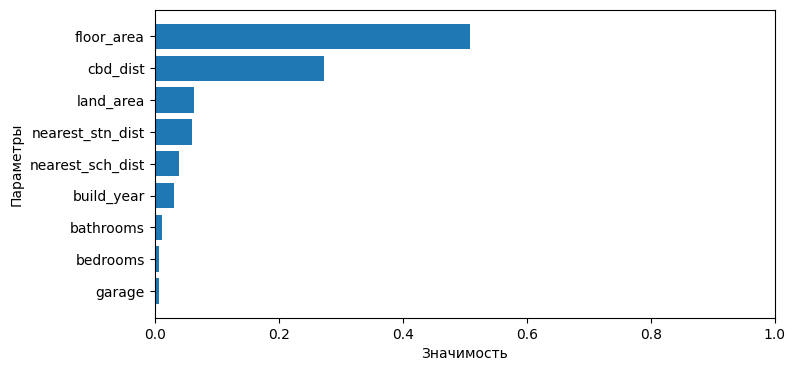

In [ ]:
#Отрисовываем значимость параметров
feature_importance_plotter(model_rf, columns_num)

В лабораторной по Регрессии я использовал Деревья решений

Проверим насколько отличается значимость
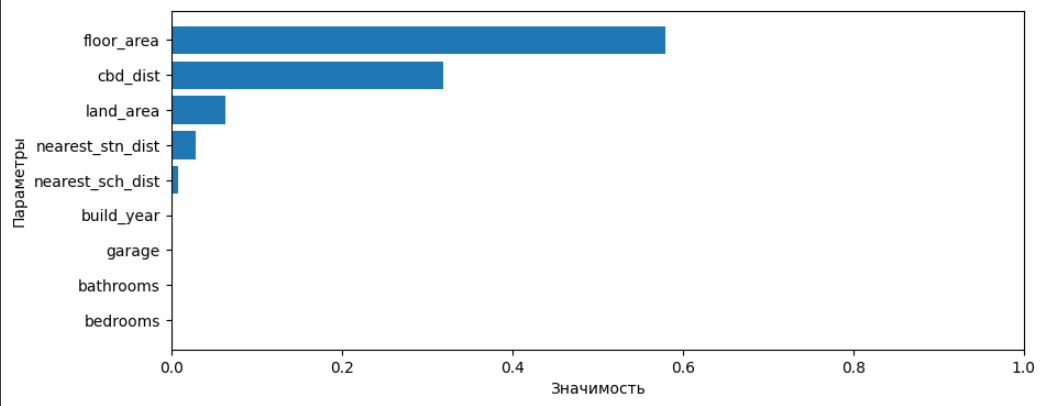

Выводы по значимости числовых признаков:
* теперь каждый признак имеет хоть какую то значимость
* значимость площади дома и расстояния до близжайшего центра повысилась
* значимость остальных признаков все также незначительная

### Оценка метрик

In [ ]:
def calculate_metric(model_pipe, X, y, metric = r2_score):
    y_model = model_pipe.predict(X)
    return metric(y, y_model)

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(model_rf, X_train_prep, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(model_rf, X_val_prep, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(model_rf, X_train_prep, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(model_rf, X_val_prep, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.8258
r2 на валидационной выборке: 0.6639
mse на тренировочной выборке: 4713003887.7119
mse на валидационной выборке: 8794714155.8925


### Кросс-валидация

In [ ]:
def cross_validation (X, y, model, scoring, cv_rule):
    scores = cross_validate(model,X, y,
                      scoring=scoring, cv=cv_rule )
    print('Ошибка на кросс-валидации')
    DF_score = pd.DataFrame(scores)
    display(DF_score)
    print('\n')
    print(DF_score.mean()[2:])

In [ ]:
scoring_reg = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           '-Max': 'max_error'}

In [ ]:
cross_validation (X_train_prep, y_train,
                  model_rf,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,7.435739,0.029621,0.718153,-8.170006e+09,-60993.908455,-644388.471362
1,6.246411,0.049765,0.697585,-8.138386e+09,-62629.944561,-527773.774252
2,7.558148,0.029670,0.648888,-8.948857e+09,-62812.116489,-632200.562567
3,6.012366,0.032294,0.686892,-7.902718e+09,-60214.046169,-462961.203291
4,7.157720,0.037385,0.667091,-8.769133e+09,-63053.088684,-635229.708114




test_R2      6.837220e-01
test_-MSE   -8.385820e+09
test_-MAE   -6.194062e+04
test_-Max   -5.805107e+05
dtype: float64


### Визуализация ошибок

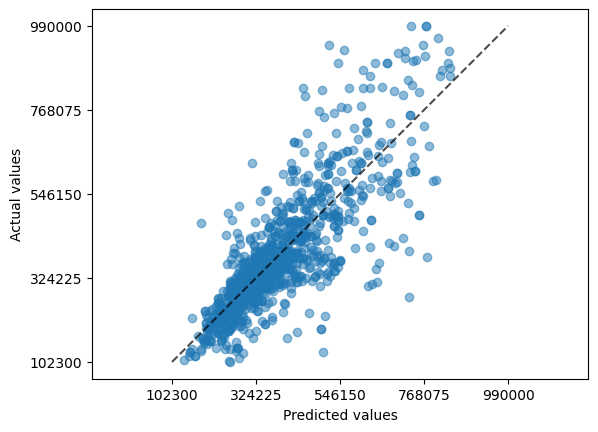

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    model_rf.predict(X_val_prep),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

Метрики простой линейной регрессии с использованием числовых признаков

*r2 на тренировочной выборке: 0.5738*

*r2 на валидационной выборке: 0.5604*

Метрики деревьев решений для линейной регрессии с использованием числовых признаков

*r2 на тренировочной выборке: 0.6027*

*r2 на валидационной выборке: 0.5583*

Выводы по модели

* Модель случайного леса лучше всех справляется с предсказанием целевой переменной (видно значительный рост r2 0.82 против 0.57 (обычная регрессия) и 0.6 (деревья решений для регрессии)), также небольшой прирост метрики на валидационной выборке

* Значимость признаков в целом похожа на ту, что была на деревьях решений, также значимость некоторых бесполезных признаков выросла (год постройки, количество ванных комнат, количество гаражей)

* Ошибки далеко расположены от предсказания

* У модели есть проблемы с предсказанием больших и средних цен

## Оценим влияние категориальных признаков

In [ ]:
# Сначала обучаем на тренировочных данных
X_train_prep = preprocessors_all.fit_transform(X_train, y_train)
# потом на валидационной
X_val_prep = preprocessors_all.transform(X_val)

In [ ]:
columns = np.hstack([num_bedrooms,
                    num_bathrooms,
                    num_garage,
                    num_land_area,
                    num_floor_area,
                    num_build_year,
                    num_cbd_dist,
                    num_nearest_stn_dist,
                    num_nearest_sch_dist,
                    cat_address,
                    cat_suburb
                    ])

In [ ]:
#Обучаем модель
model_rf_2 = RandomForestRegressor(n_estimators=150,
                                  max_depth=10,
                                  oob_score=True
                                  )

model_rf_2.fit(X_train_prep, y_train)

RandomForestRegressor(max_depth=10, n_estimators=150, oob_score=True)

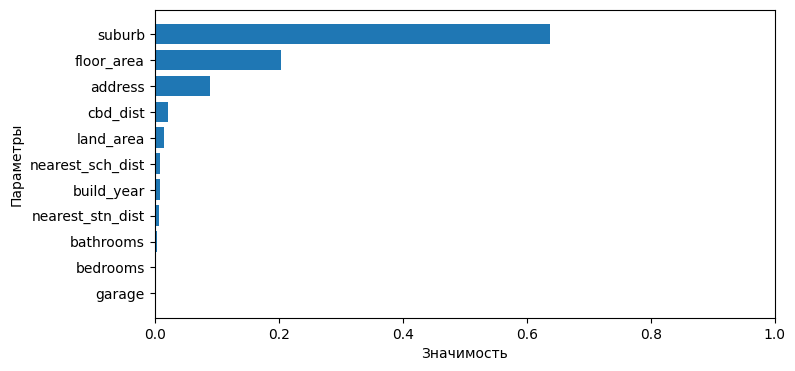

In [ ]:
#Отрисовываем значимость параметров
feature_importance_plotter(model_rf_2, columns)

В лабораторной по Регрессии я использовал Деревья решений

Проверим насколько отличается значимость
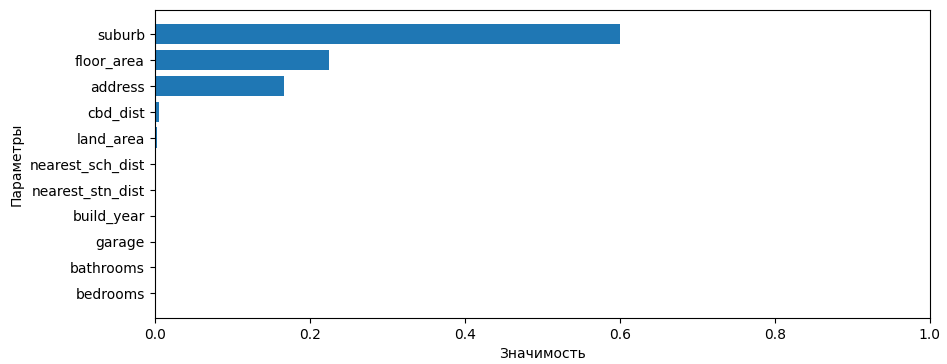

Выводы по значимости всех признаков:

* каждый признак имеет хоть какую то значимость, кроме признака количество спален и количества мест для машин (они бесполезные)
* значимость признака связанного с названием пригорода немного увеличилась
* значимость признака связанного с названием улицы уменшилась
* также выросла значимость остальных признаков (хоть и на чуть чуть)

### Оценка метрик

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(model_rf_2, X_train_prep, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(model_rf_2, X_val_prep, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(model_rf_2, X_train_prep, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(model_rf_2, X_val_prep, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.9244
r2 на валидационной выборке: 0.8197
mse на тренировочной выборке: 2046692911.2180
mse на валидационной выборке: 4719073420.6222


### Кросс-валидация

In [ ]:
cross_validation (X_train_prep, y_train,
                  model_rf_2,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,9.070633,0.029771,0.857848,-4.120609e+09,-41697.805697,-509458.532811
1,8.018585,0.039926,0.863304,-3.678667e+09,-41185.256418,-344765.063550
2,8.928400,0.029496,0.840950,-4.053742e+09,-43358.308040,-502872.277964
3,8.155914,0.036570,0.846897,-3.864266e+09,-41083.247722,-444549.525057
4,8.549681,0.031237,0.843423,-4.124380e+09,-41880.224910,-553919.218211




test_R2      8.504845e-01
test_-MSE   -3.968333e+09
test_-MAE   -4.184097e+04
test_-Max   -4.711129e+05
dtype: float64


### Визуализация ошибок

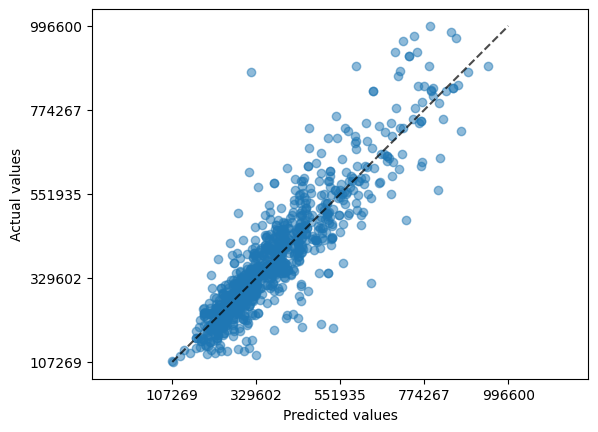

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    model_rf_2.predict(X_val_prep),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

Метрики простой линейной регрессии с использованием всех признаков

*r2 на тренировочной выборке: 0.7613*

*r2 на валидационной выборке: 0.7322*

Метрики деревьев решений для линейной регрессии с использованием всех признаков

*r2 на тренировочной выборке: 0.8100*

*r2 на валидационной выборке: 0.7384*

Небольшие выводы

* Модель случайного леса лучше всех справляется с предсказанием целевой переменной (видно значительный рост r2 0.92 против 0.82 (случайный лес с числовыми признаками) против 0.76 (обычная регрессия) и 0.81 (деревья решений для регрессии))

* Значимость признаков в целом похожа на ту, что была на деревьях решений, также значимость некоторых бесполезных признаков выросла (год постройки, количество ванных комнат, расстояние до школы и станции)

* Ошибки уже не расположены далеко от предсказания, но все же остаются проблемы с предсказанием высоких цен

## Попробуем улучшить модель

Попробуем поискать лучшие гиперпараметры для нашей модели

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [ ]:
param_grid = {
    "n_estimators": np.arange(50,300,100),
    "max_depth": np.arange(10,40,10),
}

In [ ]:
scorer = make_scorer(r2_score)

In [ ]:
RF_GS = GridSearchCV(estimator = RandomForestRegressor(),
                       param_grid=param_grid ,
                       cv=ShuffleSplit(n_splits=5, random_state=42),
                       scoring = scorer,
                       verbose = 3
                       )
RF_GS

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=None, train_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': array([10, 20, 30]),
                         'n_estimators': array([ 50, 150, 250])},
             scoring=make_scorer(r2_score), verbose=3)

In [ ]:
RF_GS.fit(X_train_prep, y_train);

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .....max_depth=10, n_estimators=50;, score=0.859 total time=   3.1s
[CV 2/5] END .....max_depth=10, n_estimators=50;, score=0.863 total time=   2.5s
[CV 3/5] END .....max_depth=10, n_estimators=50;, score=0.839 total time=   2.5s
[CV 4/5] END .....max_depth=10, n_estimators=50;, score=0.845 total time=   3.2s
[CV 5/5] END .....max_depth=10, n_estimators=50;, score=0.838 total time=   3.4s
[CV 1/5] END ....max_depth=10, n_estimators=150;, score=0.859 total time=  11.1s
[CV 2/5] END ....max_depth=10, n_estimators=150;, score=0.864 total time=  17.3s
[CV 3/5] END ....max_depth=10, n_estimators=150;, score=0.842 total time=  10.6s
[CV 4/5] END ....max_depth=10, n_estimators=150;, score=0.844 total time=  11.6s
[CV 5/5] END ....max_depth=10, n_estimators=150;, score=0.841 total time=   8.9s
[CV 1/5] END ....max_depth=10, n_estimators=250;, score=0.858 total time=  17.5s
[CV 2/5] END ....max_depth=10, n_estimators=250;,

### Оценим модель с лучшим кандидатом

In [ ]:
rf_best=RF_GS.best_estimator_
rf_best

RandomForestRegressor(max_depth=30, n_estimators=250)

In [ ]:
rf_best.fit(X_train_prep, y_train);

### Оценка метрик

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(rf_best, X_train_prep, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(rf_best, X_val_prep, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(rf_best, X_train_prep, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(rf_best, X_val_prep, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.9815
r2 на валидационной выборке: 0.8280
mse на тренировочной выборке: 500872001.1277
mse на валидационной выборке: 4500874961.0020


### Кросс-валидация

In [ ]:
cross_validation (X_train_prep, y_train,
                  rf_best,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,24.880058,0.152605,0.865692,-3.893242e+09,-40400.414470,-513485.28000
1,23.184680,0.152342,0.868588,-3.536463e+09,-40397.612078,-332295.37968
2,26.549621,0.184222,0.847897,-3.876675e+09,-42044.782091,-502213.80000
3,23.326679,0.149744,0.851167,-3.756488e+09,-40193.118917,-452001.26400
4,24.608516,0.153757,0.846186,-4.051617e+09,-41040.371147,-565000.92000




test_R2      8.559060e-01
test_-MSE   -3.822897e+09
test_-MAE   -4.081526e+04
test_-Max   -4.729993e+05
dtype: float64


### Визуализация ошибок

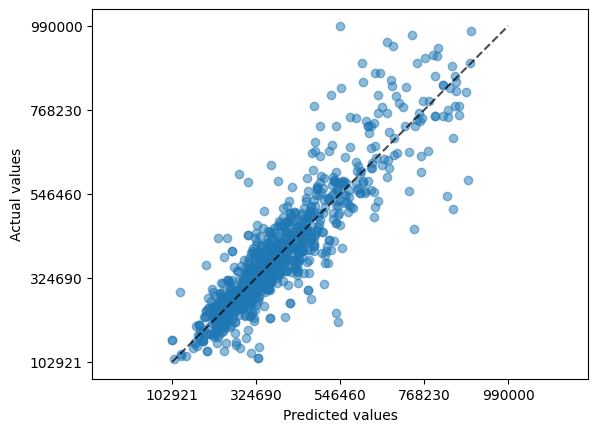

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    rf_best.predict(X_val_prep),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

Вывод по модели:

* Поиск лучших гиперпараметров позволил поднять метрику r2 с 0.92 до 0.98 на тренировочных данных, однако r2 на валидационной выборке имеет очень маленький прирост с 0.81 до 0.82

* Есть проблемы с предсказанием больших цен, а также большой разброс ошибок от предсказания, как будто даже больше, чем перед улучшением

Боюсь, что модель могла переобучиться

# Градиентный Бустинг для Регрессии

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
# Сначала обучаем на тренировочных данных
X_train_prep = preprocessors_num.fit_transform(X_train, y_train)
# потом на валидационной
X_val_prep = preprocessors_num.transform(X_val)

## Оценим модель с использованием только числовых данных

In [ ]:
#Обучаем модель
model_gb = GradientBoostingRegressor(n_iter_no_change=10,
                                    tol=0.01,
                                    learning_rate=0.1,
                                    n_estimators=150,
                                    subsample = 0.7
                                    )

model_gb.fit(X_train_prep, y_train)

GradientBoostingRegressor(n_estimators=150, n_iter_no_change=10, subsample=0.7,
                          tol=0.01)

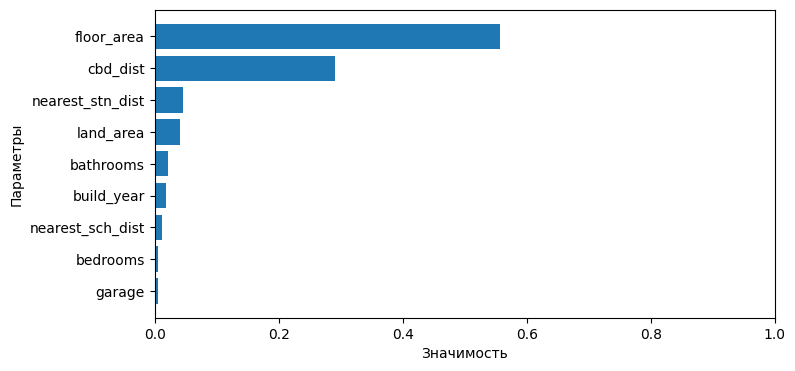

In [ ]:
#Отрисовываем значимость признаков
feature_importance_plotter(model_gb, columns_num)

В лабораторной по Регрессии я использовал Деревья решений

Проверим насколько отличается значимость
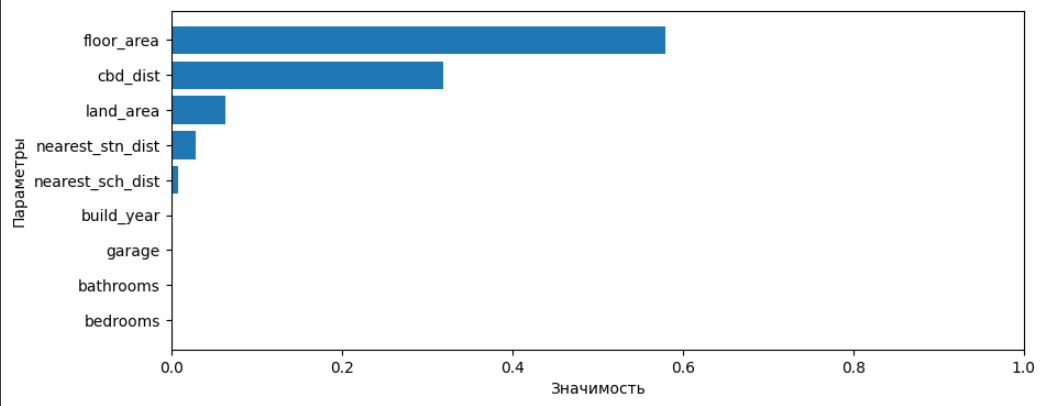

Выводы по значимости:
* теперь каждый признак имеет даже малейшую значимость
* наиболее значимые признаки остались такие же (площадь дома, расстояние до близжайшего центра)

### Оценка метрик

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(model_gb, X_train_prep, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(model_gb, X_val_prep, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(model_gb, X_train_prep, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(model_gb, X_val_prep, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.7122
r2 на валидационной выборке: 0.6526
mse на тренировочной выборке: 7788429769.3888
mse на валидационной выборке: 9091093541.9078


### Кросс-валидация

In [ ]:
cross_validation (X_train_prep, y_train,
                  model_gb,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,2.066174,0.005168,0.696425,-8.799836e+09,-64620.483825,-641433.157020
1,1.800157,0.004905,0.665766,-8.994690e+09,-66989.961185,-529020.923241
2,2.010237,0.005085,0.620175,-9.680672e+09,-67262.858350,-639038.494199
3,2.035192,0.006835,0.679450,-8.090548e+09,-62552.714489,-481358.664959
4,2.820050,0.007063,0.647968,-9.272848e+09,-66037.368185,-645560.178424




test_R2      6.619570e-01
test_-MSE   -8.967719e+09
test_-MAE   -6.549268e+04
test_-Max   -5.872823e+05
dtype: float64


### Визуализация ошибок

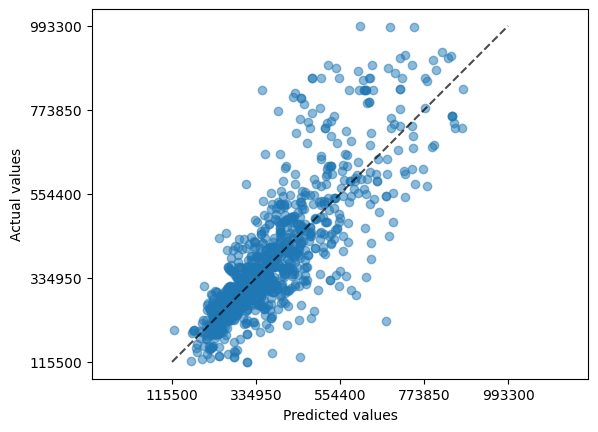

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    model_gb.predict(X_val_prep),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

Метрики простой линейной регрессии с использованием числовых признаков

*r2 на тренировочной выборке: 0.5738*

*r2 на валидационной выборке: 0.5604*

Метрики деревьев решений для линейной регрессии с использованием числовых признаков

*r2 на тренировочной выборке: 0.6027*

*r2 на валидационной выборке: 0.5583*

Метрики случайного леса с использованием числовых признаков

*r2 на тренировочной выборке: 0.8265*

*r2 на валидационной выборке: 0.6662*

Выводы по модели:
* Градиентный бустинг справляется хуже чем случайный лес 0.71 против 0.82, однако градиентный бустинг справился лучше, чем обычная линейная регрессия и деревья решений, 0.71 против 0.57 и 0.6 соотвественно
* Можно отметить, что метрика r2 на валидационной выборке близка к значению этой же метрики в случайном лесе с использованием числовых признаков
* Ошибки сильно разбросаны вокруг предсказания

Посмотрим как повлияют категориальные признаки

## Оценим влияние категориальных признаков

In [ ]:
# Сначала обучаем на тренировочных данных
X_train_prep = preprocessors_all.fit_transform(X_train, y_train)
# потом на валидационной
X_val_prep = preprocessors_all.transform(X_val)

In [ ]:
#Обучаем модель
model_gb_2 = GradientBoostingRegressor(n_iter_no_change=10,
                                      tol=0.01,
                                      learning_rate=0.1,
                                      n_estimators=150,
                                      subsample = 0.7
                                      )

model_gb_2.fit(X_train_prep, y_train)

GradientBoostingRegressor(n_estimators=150, n_iter_no_change=10, subsample=0.7,
                          tol=0.01)

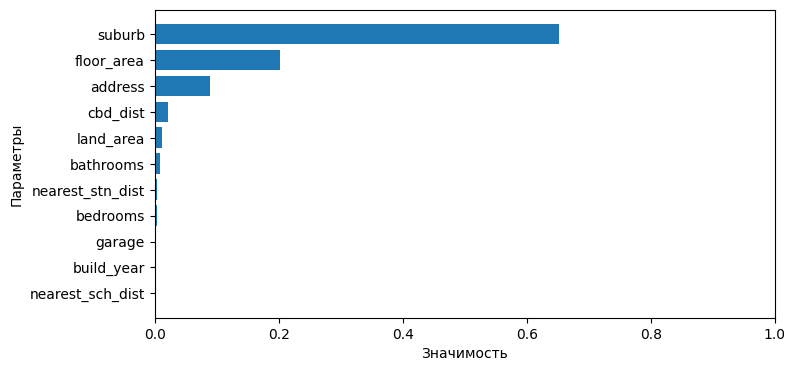

In [ ]:
#Отрисовываем значимость признаков
feature_importance_plotter(model_gb_2, columns)

В лабораторной по Регрессии я использовал Деревья решений

Проверим насколько отличается значимость
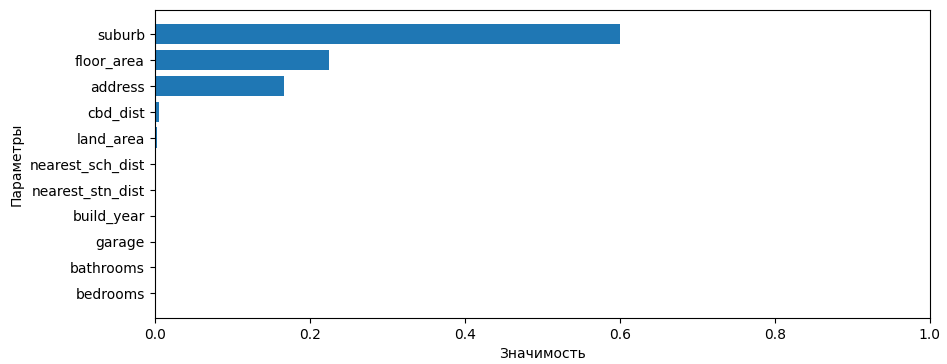

Выводы по значимости всех признаков:

* каждый признак имеет хоть какую то значимость, кроме признака количества меств для машин, года постройки и расстояния до близжайшей школы (они бесполезные)
* значимость признака связанного с названием улицы уменшилась
* также выросла значимость остальных признаков (хоть и на чуть чуть)

### Оценка метрик

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(model_gb_2, X_train_prep, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(model_gb_2, X_val_prep, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(model_gb_2, X_train_prep, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(model_gb_2, X_val_prep, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.8772
r2 на валидационной выборке: 0.8186
mse на тренировочной выборке: 3324145823.1217
mse на валидационной выборке: 4748167660.5586


### Кросс-валидация

In [ ]:
cross_validation (X_train_prep, y_train,
                  model_gb_2,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,1.704762,0.004996,0.853889,-4.235373e+09,-43508.760212,-533283.006202
1,2.448769,0.004932,0.854826,-3.906825e+09,-42462.281659,-380959.373336
2,1.783828,0.005890,0.827846,-4.387735e+09,-45016.960525,-504826.366031
3,3.392706,0.006651,0.854060,-3.683454e+09,-41169.702605,-401666.406389
4,2.332077,0.004852,0.841399,-4.177701e+09,-43122.351899,-539216.559369




test_R2      8.464041e-01
test_-MSE   -4.078217e+09
test_-MAE   -4.305601e+04
test_-Max   -4.719903e+05
dtype: float64


### Визуализация ошибок от scikit-learn

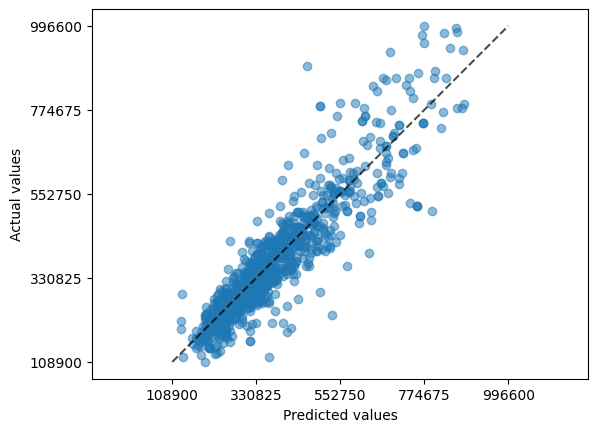

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    model_gb_2.predict(X_val_prep),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

Метрики простой линейной регрессии с использованием всех признаков

*r2 на тренировочной выборке: 0.7613*

*r2 на валидационной выборке: 0.7322*

Метрики деревьев решений для линейной регрессии с использованием всех признаков

*r2 на тренировочной выборке: 0.8100*

*r2 на валидационной выборке: 0.7384*

Метрики случайного леса с использованием всех признаков

*r2 на тренировочной выборке: 0.9246*

*r2 на валидационной выборке: 0.8193*

Выводы по модели:
* по итогу можно сказать, что итоговые метрики не стали лучше, чем в случайном лесе (итоговая метрика r2 0.87 против 0.92)
* метрика r2 на валидационной выборке почти равна такой же метрики, полученной при применении случайного леса
* однако ошибки не так сильно разбросаны вокруг предсказания

## Попробуем улучшить модель

In [ ]:
param_grid = {
    "n_estimators": np.arange(50,300,100),
    "max_depth": np.arange(10,40,10),
}

In [ ]:
scorer = make_scorer(r2_score)

In [ ]:
GB_GS = GridSearchCV(estimator = GradientBoostingRegressor(),
                       param_grid=param_grid ,
                       cv=ShuffleSplit(n_splits=5, random_state=42),
                       scoring = scorer,
                       verbose = 3
                       )
GB_GS

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=None, train_size=None),
             estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': array([10, 20, 30]),
                         'n_estimators': array([ 50, 150, 250])},
             scoring=make_scorer(r2_score), verbose=3)

In [ ]:
GB_GS.fit(X_train_prep, y_train);

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .....max_depth=10, n_estimators=50;, score=0.866 total time=   4.5s
[CV 2/5] END .....max_depth=10, n_estimators=50;, score=0.866 total time=   3.7s
[CV 3/5] END .....max_depth=10, n_estimators=50;, score=0.848 total time=   4.1s
[CV 4/5] END .....max_depth=10, n_estimators=50;, score=0.844 total time=   4.8s
[CV 5/5] END .....max_depth=10, n_estimators=50;, score=0.843 total time=   3.7s
[CV 1/5] END ....max_depth=10, n_estimators=150;, score=0.865 total time=  12.5s
[CV 2/5] END ....max_depth=10, n_estimators=150;, score=0.865 total time=  12.0s
[CV 3/5] END ....max_depth=10, n_estimators=150;, score=0.846 total time=  11.7s
[CV 4/5] END ....max_depth=10, n_estimators=150;, score=0.844 total time=  12.5s
[CV 5/5] END ....max_depth=10, n_estimators=150;, score=0.845 total time=  12.6s
[CV 1/5] END ....max_depth=10, n_estimators=250;, score=0.863 total time=  20.7s
[CV 2/5] END ....max_depth=10, n_estimators=250;,

### Оценим модель с лучшим кандидатом

In [ ]:
gb_best=GB_GS.best_estimator_
gb_best

GradientBoostingRegressor(max_depth=10, n_estimators=50)

In [ ]:
gb_best.fit(X_train_prep, y_train);

### Оценка метрик

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(gb_best, X_train_prep, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(gb_best, X_val_prep, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(gb_best, X_train_prep, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(gb_best, X_val_prep, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.9799
r2 на валидационной выборке: 0.8223
mse на тренировочной выборке: 542714243.5578
mse на валидационной выборке: 4649176358.8242


### Кросс-валидация

In [ ]:
cross_validation (X_train_prep, y_train,
                  gb_best,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,5.217949,0.008096,0.864409,-3.930440e+09,-41358.464713,-454157.635502
1,3.715869,0.008293,0.862970,-3.687663e+09,-40687.184901,-368052.566127
2,3.689296,0.008122,0.846565,-3.910619e+09,-42504.973152,-459432.343398
3,4.232414,0.010821,0.842523,-3.974643e+09,-41189.915611,-577903.321621
4,4.809162,0.008191,0.845543,-4.068555e+09,-41155.324073,-536979.471886




test_R2      8.524020e-01
test_-MSE   -3.914384e+09
test_-MAE   -4.137917e+04
test_-Max   -4.793051e+05
dtype: float64


### Визуализация ошибок

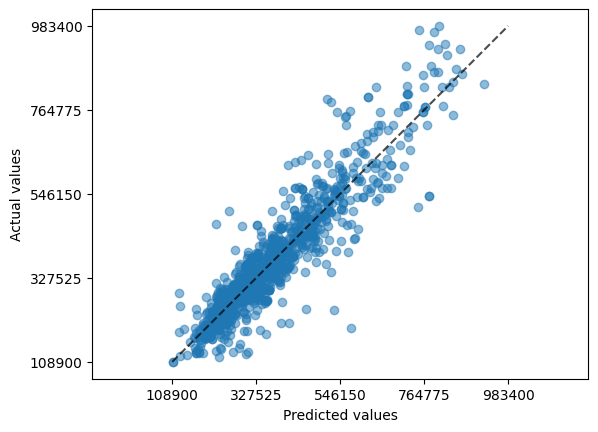

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    gb_best.predict(X_val_prep),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

Вывод по модели:

* Поиск лучших гиперпараметров позволил поднять метрику r2 с 0.87 до 0.97 на тренировочных данных, однако r2 на валидационной выборке имеет очень маленький прирост с 0.81 до 0.82
* Также можно отметить, что ошибки расположены не сильно далеко от предсказаний, однако все же есть сильно удаленные ошибки

Боюсь, что и эта модель могла переобучиться

# Общий вывод по моделям

Случайный лес показывал самые высокие метрики из всех рассмотренных моделей (метрика r2 0.98 против 0.97 (градиентный бустинг улучшенный), 0.87 (деревья решений) и 0.76 (линейная регрессия)). Также метрика на валидационной выьорке выше у случайного леса

Однако в улучшенном случайном лесе и градиентном бустинге метрика на тренировочных данных показывает значения близкие к 1 (0.98 и 0.97), боюсь, что могло быть переобучение.

Также хочу отметить, что визуализация ошибок лучше все выглядит у улучшенного градиентного бустинга (лучше - ошибки сильно не удалены от предсказания, ну и просто выглядит приятнее глазу большие скопления на линии предсказания, а не разбросанные синие точки)

# Бустинг от CatBoost

## Подготовка данных

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.5 MB/s eta 0:00:00


In [ ]:
#Удаляем целевую переменную из признаков (цена на дом)
X, y = df.drop(columns = ['price']), df['price']
features_names = list(df.drop(columns = ["price"]).columns)

#Разбиваем на тестовую и валидационную
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

In [ ]:
from catboost import Pool

In [ ]:
train_data_reg = Pool(
    data=X_train,
    label=y_train,
    cat_features = cat_columns,
    feature_names=features_names,
)

eval_data_reg = Pool(
    data=X_val,
    label=y_val,
    cat_features = cat_columns,
    feature_names=features_names
)

## Составление модели

In [ ]:
from catboost import CatBoostRegressor

In [ ]:
model_reg = CatBoostRegressor(iterations = 1000,
                            early_stopping_rounds=100,
                            verbose = 100,
                            cat_features = cat_columns,
                            depth = 3,
                            objective  = 'MAE',
                            eval_metric= 'MAE',
                            random_state = 42
                           )

In [ ]:
model_reg.fit(X=train_data_reg,
          eval_set=eval_data_reg,
          )

0:	learn: 117922.0053688	test: 115210.0598677	best: 115210.0598677 (0)	total: 69.1ms	remaining: 1m 9s
100:	learn: 58950.2704657	test: 55629.1810454	best: 55629.1810454 (100)	total: 1.77s	remaining: 15.8s
200:	learn: 54194.0803244	test: 51246.6596502	best: 51246.6596502 (200)	total: 3.92s	remaining: 15.6s
300:	learn: 52576.9098603	test: 49883.8272968	best: 49883.8272968 (300)	total: 5.89s	remaining: 13.7s
400:	learn: 51389.1683741	test: 49031.1677418	best: 49031.1677418 (400)	total: 8.36s	remaining: 12.5s
500:	learn: 50498.7621952	test: 48439.4025845	best: 48439.3613409 (499)	total: 11.5s	remaining: 11.4s
600:	learn: 49799.3935852	test: 48017.1408279	best: 48017.1408279 (600)	total: 13s	remaining: 8.66s
700:	learn: 49261.5315499	test: 47627.2229880	best: 47627.2229880 (700)	total: 14.6s	remaining: 6.21s
800:	learn: 48770.4821800	test: 47315.5441937	best: 47314.9716463 (798)	total: 16.4s	remaining: 4.09s
900:	learn: 48355.5941641	test: 47068.3984788	best: 47068.3984788 (900)	total: 17.9s

In [ ]:
def feature_importance_plotter(model, features_names):
    feature_importance = model.feature_importances_

    sorted = np.argsort(feature_importance)

    ypos = np.arange(len(features_names))

    fig= plt.figure(figsize=(8,4))
    plt.barh(ypos, feature_importance[sorted])
    plt.ylabel('Параметры')
    plt.xlabel('Значимость')
    plt.yticks(ypos,features_names[sorted] );

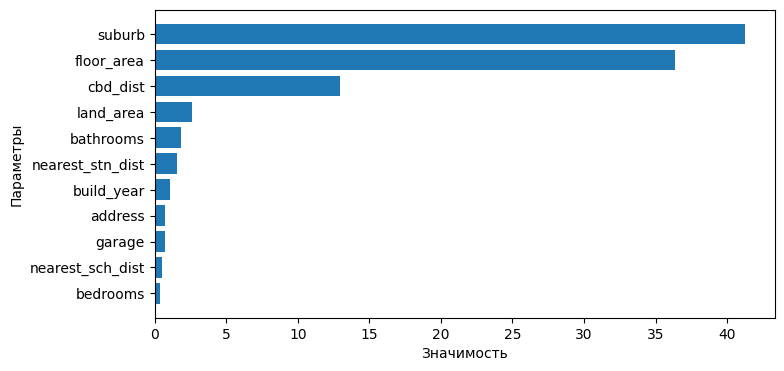

In [ ]:
#Отрисовываем значимость признаков
feature_importance_plotter(model_reg, np.array(features_names))

Вывод по значимости:
* В сравнении с прошлыми отрисовками значимости, такие признаки как пригород и площадь дома остались самыми значимыми, теперь одним из значимых стал признак расстояния до близжайшего центра
* Признак связанный с названием улицы стал почти незначимый, хотя в других моделях имел неплохую значимость
* Также все признаки имеют хоть какую то значимость

## Оценка метрик

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(model_reg, train_data_reg, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(model_reg, eval_data_reg, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(model_reg, train_data_reg, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(model_reg, eval_data_reg, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.8263
r2 на валидационной выборке: 0.8063
mse на тренировочной выборке: 4700813696.1749
mse на валидационной выборке: 5067931039.2383


## Кросс-валидация

In [ ]:
cross_validation (X_train, y_train,
                  model_reg,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

0:	learn: 117543.5500837	total: 15.1ms	remaining: 15.1s
100:	learn: 59836.9367191	total: 1.37s	remaining: 12.2s
200:	learn: 55184.5433084	total: 2.77s	remaining: 11s
300:	learn: 53473.4356341	total: 3.94s	remaining: 9.14s
400:	learn: 52228.4841834	total: 5.08s	remaining: 7.58s
500:	learn: 51243.5543685	total: 6.1s	remaining: 6.08s
600:	learn: 50497.1132259	total: 6.78s	remaining: 4.5s
700:	learn: 49839.1438872	total: 7.36s	remaining: 3.14s
800:	learn: 49317.5086932	total: 7.9s	remaining: 1.96s
900:	learn: 48832.0993329	total: 8.47s	remaining: 931ms
999:	learn: 48443.1416735	total: 9.04s	remaining: 0us
0:	learn: 118071.3524889	total: 7.35ms	remaining: 7.34s
100:	learn: 60195.1744576	total: 564ms	remaining: 5.02s
200:	learn: 55370.4411758	total: 1.17s	remaining: 4.67s
300:	learn: 53656.6265089	total: 1.74s	remaining: 4.05s
400:	learn: 52376.7494752	total: 2.33s	remaining: 3.47s
500:	learn: 51448.1742013	total: 2.85s	remaining: 2.84s
600:	learn: 50694.3061190	total: 3.42s	remaining: 2.27s

,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,9.282710,0.015838,0.833009,-4.840626e+09,-45625.202904,-571509.083486
1,5.911386,0.009768,0.805055,-5.246246e+09,-47418.225155,-492938.206118
2,8.794687,0.009982,0.793284,-5.268606e+09,-47670.230433,-582790.971753
3,5.914062,0.009898,0.820659,-4.526494e+09,-45362.423672,-396148.915989
4,8.740333,0.010561,0.797679,-5.329331e+09,-47424.937354,-577098.003456




test_R2      8.099372e-01
test_-MSE   -5.042261e+09
test_-MAE   -4.670020e+04
test_-Max   -5.240970e+05
dtype: float64


## Визуализация ошибок

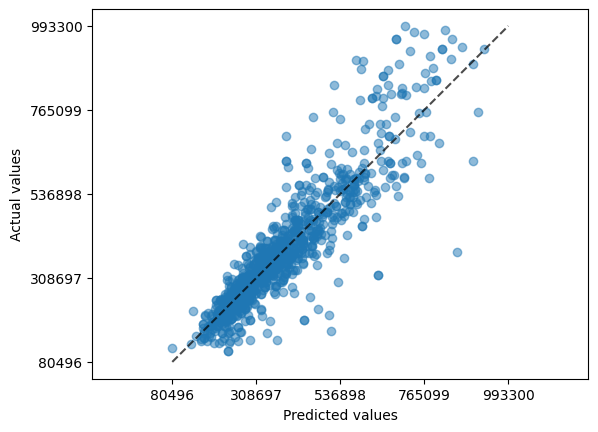

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    model_reg.predict(eval_data_reg),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

Выводы по модели:
* Метрики модели уступают улучшенным моделям градиентного бустинга и случайного леса 0.82 против 0.97 и 0.98, однако если смотреть на метрику на валидационных данных, то можно увидеть незначительное отставание 0.8 против 0.82
* Если говорить про распределение ошибок, то есть проблемы с предсказанием больших цен

## Оптимизация гиперпараметров

In [ ]:
from scipy import stats

model = CatBoostRegressor(
    random_seed=42,
    thread_count=-1,
    cat_features=cat_columns,
    eval_metric="RMSE",
    verbose=500,
)

param_distribution = {
    "one_hot_max_size": stats.bernoulli(p=0.2, loc=2),
    "learning_rate": [0.03, 0.1, 0.3],
    "l2_leaf_reg": [2, 5, 7],
    "depth": stats.binom(n=10, p=0.2),
}
randomized_search_result = model.randomized_search(param_distribution, X_train, y_train)
model.best_score_

0:	learn: 405371.4112487	test: 399753.9237855	best: 399753.9237855 (0)	total: 4.99ms	remaining: 4.99s
500:	learn: 79117.2975403	test: 76391.8129406	best: 76387.5183401 (498)	total: 1.63s	remaining: 1.62s
999:	learn: 75880.6189665	test: 74424.8690098	best: 74423.0454987 (998)	total: 3.08s	remaining: 0us

bestTest = 74423.0455
bestIteration = 998

0:	loss: 74423.0454987	best: 74423.0454987 (0)	total: 3.13s	remaining: 28.2s
0:	learn: 406023.1844656	test: 400349.8182399	best: 400349.8182399 (0)	total: 1.67ms	remaining: 1.67s
500:	learn: 165430.3440168	test: 160750.7517256	best: 160698.1870636 (148)	total: 779ms	remaining: 776ms
999:	learn: 165430.3440168	test: 160750.7540376	best: 160698.1870636 (148)	total: 1.56s	remaining: 0us

bestTest = 160698.1871
bestIteration = 148

1:	loss: 160698.1870636	best: 74423.0454987 (0)	total: 4.71s	remaining: 18.8s
0:	learn: 405197.8588762	test: 399635.9929358	best: 399635.9929358 (0)	total: 6.33ms	remaining: 6.32s
500:	learn: 74881.5229804	test: 73642.95

{'learn': {'RMSE': 54042.71931208051}}

In [ ]:
# Лучшие параметры модели из перебора
randomized_search_result["params"]

{'l2_leaf_reg': 5, 'depth': 3.0, 'one_hot_max_size': 3.0, 'learning_rate': 0.3}

### Оценка метрик

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(model, train_data_reg, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(model, eval_data_reg, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(model, train_data_reg, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(model, eval_data_reg, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.9037
r2 на валидационной выборке: 0.8283
mse на тренировочной выборке: 2605252960.0304
mse на валидационной выборке: 4493558295.6530


### Визуализация ошибок

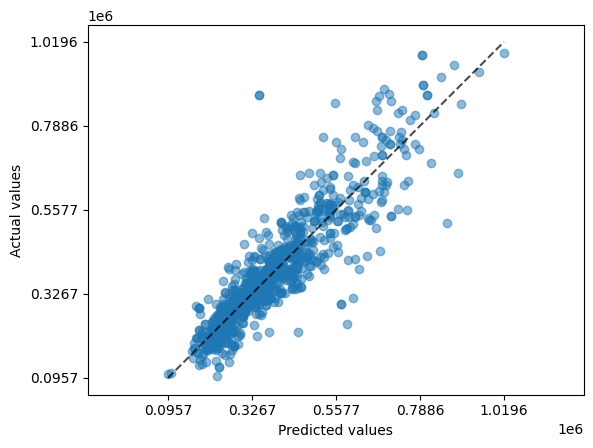

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    model.predict(eval_data_reg),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

Выводы по модели:
* Оптимизация гиперпараметров помогла улучшить метрику модели 0.9 против 0.82, но это все еще ниже, чем у прошлых моделей, однако стоит отметить, что r2 на валидационной выборке показал пока что самый лучший результат 0.8283 против 0.8223 (град. бустинг) и 0.8280 (случ. лес)
* Впринципе ошибки выглядят не супер отдалено от предсказания, но все же есть сильно откланяющиеся ошибки

# Бустинг от XGBoost

## Подготовка данных

In [ ]:
#Удаляем целевую переменную из признаков (цена на дом)
X, y = df.drop(columns = ['price']), df['price']
features_names = list(df.drop(columns = ["price"]).columns)

for col in cat_columns:
    X[col] = X[col].astype('category')

#Разбиваем на тестовую и валидационную
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

In [ ]:
import xgboost as xgb

In [ ]:
dtrain = xgb.DMatrix(X_train,
                     label=y_train,
                     enable_categorical=True)

dval = xgb.DMatrix(X_val,
                    y_val,
                    enable_categorical=True)

## Составление модели

In [ ]:
model_reg_2 = xgb.XGBRegressor(random_state = 42,
                              objective= 'reg:squarederror',
                              enable_categorical=True,
                              early_stopping_rounds=50,
                              n_estimators=500,
                              )

In [ ]:
model_reg_2.fit(X_train,y_train,
          eval_set=[(X_train, y_train), (X_val, y_val)]);

[0]	validation_0-rmse:122960.31614	validation_1-rmse:129625.65642
[1]	validation_0-rmse:94181.54498	validation_1-rmse:109483.72709
[2]	validation_0-rmse:74771.93254	validation_1-rmse:97421.20314
[3]	validation_0-rmse:60936.95371	validation_1-rmse:88820.52664
[4]	validation_0-rmse:51850.40594	validation_1-rmse:84042.70282
[5]	validation_0-rmse:45466.20686	validation_1-rmse:80822.40740
[6]	validation_0-rmse:41055.94962	validation_1-rmse:78848.51351
[7]	validation_0-rmse:38142.86272	validation_1-rmse:77785.65682
[8]	validation_0-rmse:35567.56146	validation_1-rmse:76628.89527
[9]	validation_0-rmse:33688.77045	validation_1-rmse:76082.12507
[10]	validation_0-rmse:32324.07945	validation_1-rmse:75602.80448
[11]	validation_0-rmse:30987.38787	validation_1-rmse:75091.64355
[12]	validation_0-rmse:30154.22535	validation_1-rmse:74937.73077
[13]	validation_0-rmse:29438.55479	validation_1-rmse:74883.83137
[14]	validation_0-rmse:28889.58009	validation_1-rmse:74796.21817
[15]	validation_0-rmse:28492.756

In [ ]:
print("Лучшая Итерация: {}".format(model_reg_2.get_booster().best_iteration))

Лучшая Итерация: 16


In [ ]:
def feature_importance_plotter(model, features_names):
    feature_importance = model.feature_importances_

    sorted = np.argsort(feature_importance)

    ypos = np.arange(len(features_names))

    fig= plt.figure(figsize=(8,4))
    plt.barh(ypos, feature_importance[sorted])
    plt.xlim([0,1])
    plt.ylabel('Параметры')
    plt.xlabel('Значимость')
    plt.yticks(ypos,features_names[sorted] );

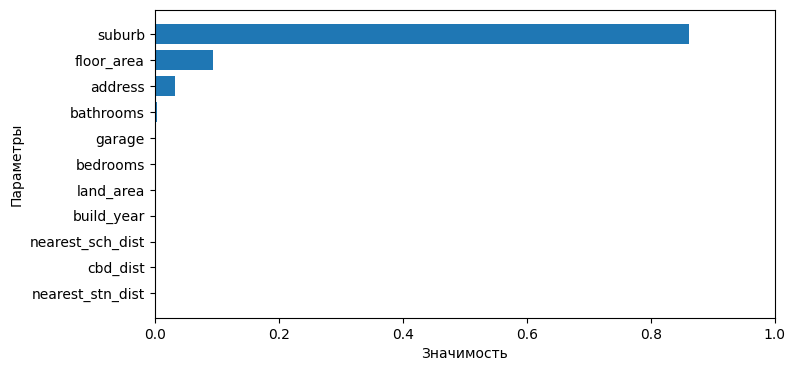

In [ ]:
feature_importance_plotter(model_reg_2, np.array(features_names))

Вывод по значимости:
* Признак пригорода имеет самую высокую значимость, она выше, чем в других моделях
* Признаки площади дома и улицы все еще остаются значимыми хоть и немного, как и в других моделях
* Остальные признаки бесполезны, в других моделях остальные признаки имели хотя небольшую значимость

## Оценка метрик

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(model_reg_2, X_train, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(model_reg_2, X_val, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(model_reg_2, X_train, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(model_reg_2, X_val, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.9721
r2 на валидационной выборке: 0.7873
mse на тренировочной выборке: 754254810.2266
mse на валидационной выборке: 5567444445.0726


*Пробовал написать функцию для кросс валидации через chatGPT, но, к сожалению, у меня не получилось*

*Внизу оставил наброски, может было недалеко до истины*

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

def cross_validate_xgboost_with_metrics(params, dtrain, num_boost_round, nfold=5, early_stopping_rounds=None):
    def custom_eval_mse(preds, dtrain):
        labels = dtrain.get_label()
        return 'mse', mean_squared_error(labels, preds)

    def custom_eval_r2(preds, dtrain):
        labels = dtrain.get_label()
        return 'r2', r2_score(labels, preds)

    custom_eval = [(dtrain, 'train'), (dtrain, 'eval')]

    bst = xgb.train(
        params, dtrain, num_boost_round, evals=custom_eval, early_stopping_rounds=early_stopping_rounds, verbose_eval=False
    )

    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        nfold=nfold,
        early_stopping_rounds=early_stopping_rounds,
        feval=custom_eval_mse,  # Добавляем пользовательскую функцию для MSE
        maximize=False,
        seed=42,
        as_pandas=True
    )

    cv_results['test-r2-mean'] = cv_results['test-r2-mean'].iloc[-1]  # Записываем последнее значение R²

    return cv_results


In [ ]:
params = {
    "objective": "reg:squarederror",
    "random_state": 42,
    "enable_categorical": True,
}

num_boost_round = 1000  # Примерное количество итераций

cv_results = cross_validate_xgboost_with_metrics(params, dtrain, num_boost_round)
print(cv_results)

## Визуализация ошибок

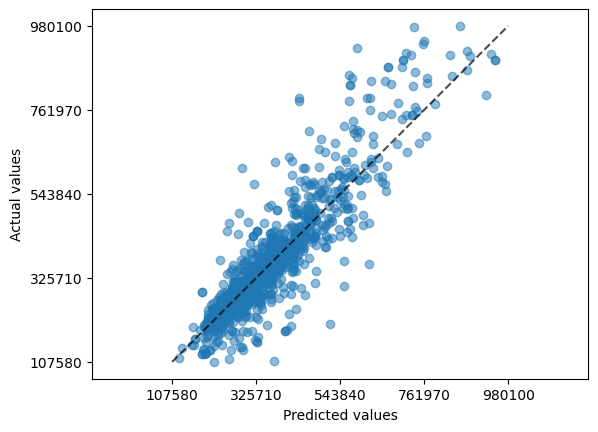

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    model_reg_2.predict(X_val),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

Выводы по модели:
* Метрики на тестовой выборке показывают высокий результат на уровне улучшенного градиентного бустинга и случайного леса, однако метрика на валидационной выборке самая худшая из всех моделей
* Если смотреть на ошибки, то достаточно много ошибок сильно удаленных от предсказания

## Оптимизация гиперпараметров

Рассмотрим, что нам покажет модель, если использовать только топовые признаки или вообще их не использовать

In [ ]:
#Решил обучать параллельно два df
#DF_1 будет содержать топовые признаки suburb, address и floor_area
DF_1 = df.copy()
DF_1 = DF_1.drop(columns = ['bathrooms'])
DF_1 = DF_1.drop(columns = ['garage'])
DF_1 = DF_1.drop(columns = ['bedrooms'])
DF_1 = DF_1.drop(columns = ['land_area'])
DF_1 = DF_1.drop(columns = ['build_year'])
DF_1 = DF_1.drop(columns = ['nearest_sch_dist'])
DF_1 = DF_1.drop(columns = ['cbd_dist'])

In [ ]:
#DF_2 будет без топовых признаков
DF_2 = df.copy()
DF_2 = DF_2.drop(columns = ['suburb'])
DF_2 = DF_2.drop(columns = ['address'])
DF_2 = DF_2.drop(columns = ['floor_area'])

In [ ]:
#Удаляем целевую переменную из признаков (цена на дом)
X1, y1 = DF_1.drop(columns = ['price']), DF_1['price']
features_names = list(DF_1.drop(columns = ["price"]).columns)

for col in DF_1[cat_columns]:
  X1[col] = X1[col].astype('category')

#Разбиваем на тестовую и валидационную
X_train1, X_val1, y_train1, y_val1 = train_test_split(X1, y1,
                                                    test_size=0.3,
                                                    random_state=42)

In [ ]:
#Удаляем целевую переменную из признаков (цена на дом)
X2, y2 = DF_2.drop(columns = ['price']), DF_2['price']
features_names = list(DF_2.drop(columns = ["price"]).columns)

#Разбиваем на тестовую и валидационную
X_train2, X_val2, y_train2, y_val2 = train_test_split(X2, y2,
                                                    test_size=0.3,
                                                    random_state=42)

In [ ]:
dtrain1 = xgb.DMatrix(X_train1,
                     label=y_train1,
                     enable_categorical=True)

dval1 = xgb.DMatrix(X_val1,
                    y_val1,
                    enable_categorical=True)

####################################################

dtrain2 = xgb.DMatrix(X_train2,
                     label=y_train2,
                     enable_categorical=True)

dval2 = xgb.DMatrix(X_val2,
                    y_val2,
                    enable_categorical=True)

In [ ]:
#Обучаем первую модель, где топовые признаки
model_reg_v1 = xgb.XGBRegressor(random_state = 42,
                              objective= 'reg:squarederror',
                              enable_categorical=True,
                              early_stopping_rounds=50,
                              n_estimators=500,
                              )
model_reg_v1.fit(X_train1,y_train1,
          eval_set=[(X_train1, y_train1), (X_val1, y_val1)]);

[0]	validation_0-rmse:122960.63278	validation_1-rmse:129621.95648
[1]	validation_0-rmse:94192.19794	validation_1-rmse:109460.47359
[2]	validation_0-rmse:74754.70050	validation_1-rmse:97569.02392
[3]	validation_0-rmse:61406.70841	validation_1-rmse:89256.51795
[4]	validation_0-rmse:51999.53089	validation_1-rmse:84197.88465
[5]	validation_0-rmse:45750.74368	validation_1-rmse:81276.68263
[6]	validation_0-rmse:41204.22354	validation_1-rmse:78975.54831
[7]	validation_0-rmse:37892.09418	validation_1-rmse:77627.93831
[8]	validation_0-rmse:35764.53181	validation_1-rmse:76947.82591
[9]	validation_0-rmse:34121.44011	validation_1-rmse:76261.52354
[10]	validation_0-rmse:32949.19047	validation_1-rmse:76082.53766
[11]	validation_0-rmse:32338.34381	validation_1-rmse:75913.55021
[12]	validation_0-rmse:31587.02005	validation_1-rmse:75701.03191
[13]	validation_0-rmse:30901.37874	validation_1-rmse:75684.94866
[14]	validation_0-rmse:30295.84916	validation_1-rmse:75634.66849
[15]	validation_0-rmse:30053.072

In [ ]:
print("Лучшая Итерация: {}".format(model_reg_v1.get_booster().best_iteration))

Лучшая Итерация: 19


In [ ]:
#Обучаем вторую модель, где удалены топовые признаки
model_reg_v2 = xgb.XGBRegressor(random_state = 42,
                              objective= 'reg:squarederror',
                              enable_categorical=True,
                              early_stopping_rounds=50,
                              n_estimators=500,
                              )
model_reg_v2.fit(X_train2,y_train2,
          eval_set=[(X_train2, y_train2), (X_val2, y_val2)]);

[0]	validation_0-rmse:145454.57118	validation_1-rmse:144503.61802
[1]	validation_0-rmse:133286.57364	validation_1-rmse:133885.26178
[2]	validation_0-rmse:125850.64014	validation_1-rmse:128277.45567
[3]	validation_0-rmse:120468.88593	validation_1-rmse:124047.93960
[4]	validation_0-rmse:117023.60129	validation_1-rmse:121643.69102
[5]	validation_0-rmse:113824.38462	validation_1-rmse:119289.91824
[6]	validation_0-rmse:112123.50952	validation_1-rmse:118350.33609
[7]	validation_0-rmse:110143.85041	validation_1-rmse:117248.50270
[8]	validation_0-rmse:108723.91207	validation_1-rmse:116735.84480
[9]	validation_0-rmse:107580.10084	validation_1-rmse:116181.05581
[10]	validation_0-rmse:106853.76216	validation_1-rmse:115927.28618
[11]	validation_0-rmse:104853.33291	validation_1-rmse:114622.31005
[12]	validation_0-rmse:103830.36254	validation_1-rmse:114080.86786
[13]	validation_0-rmse:101999.53705	validation_1-rmse:112730.70693
[14]	validation_0-rmse:100764.55768	validation_1-rmse:112180.71799
[15]	

In [ ]:
print("Лучшая Итерация: {}".format(model_reg_v2.get_booster().best_iteration))

Лучшая Итерация: 101


### Оценка метрик

In [ ]:
print(f"r2 с топовыми на тестовой: {calculate_metric(model_reg_v1, X_train1, y_train1):.4f} без топовых: {calculate_metric(model_reg_v2, X_train2, y_train2):.4f}")
print(f"r2 с топовыми валидационной: {calculate_metric(model_reg_v1, X_val1, y_val1):.4f} без топовых: {calculate_metric(model_reg_v2, X_val2, y_val2):.4f}")

print(f"mse с топовыми на тестовой: {calculate_metric(model_reg_v1, X_train1, y_train1, mse):.4f} без топовых: {calculate_metric(model_reg_v2, X_train2, y_train2, mse):.4f}")
print(f"mse с топовыми валидационной: {calculate_metric(model_reg_v1, X_val1, y_val1, mse):.4f} без топовых: {calculate_metric(model_reg_v2, X_val2, y_val2, mse):.4f}")

r2 с топовыми на тестовой: 0.9693 без топовых: 0.8517
r2 с топовыми валидационной: 0.7824 без топовых: 0.5859
mse с топовыми на тестовой: 829620835.9667 без топовых: 4013513054.0375
mse с топовыми валидационной: 5694983805.3173 без топовых: 10837703852.8128


### Визуализация ошибок

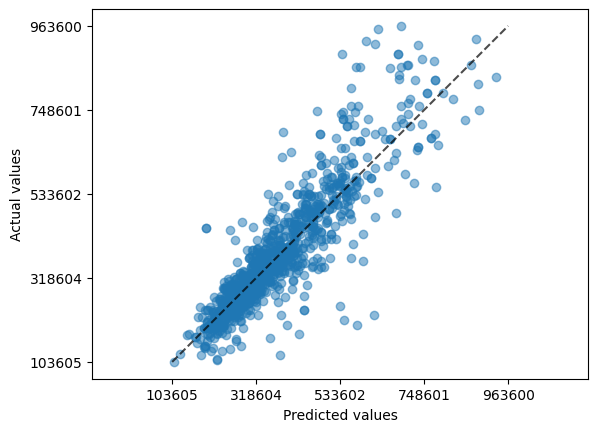

In [ ]:
#Ошибки модели с топовыми признаками
PredictionErrorDisplay.from_predictions(
    y_val1,
    model_reg_v1.predict(X_val1),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

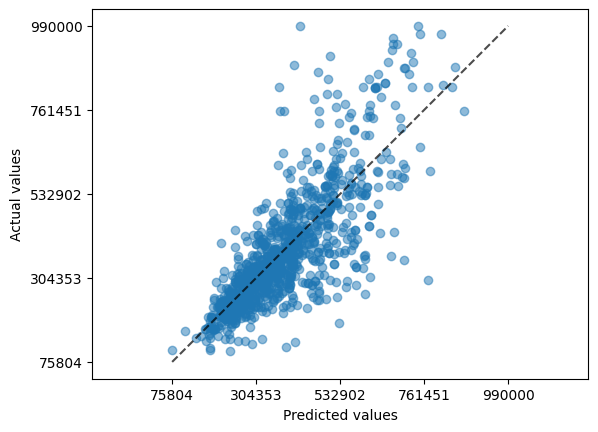

In [ ]:
#Ошибки модели без топовых признаков
PredictionErrorDisplay.from_predictions(
    y_val2,
    model_reg_v2.predict(X_val2),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

Выводы по модели:
* Метрики показывают лучший вариант при использовании только топовых признаков 0.96 против 0.85 на тренировочной выборке и 0.78 и 0.58 на валидацинной (опять на тренировочной высокий результат намного больше, чем на валидацонной)
* При сравнении графиков видно, на первом есть проблемы с определением высокой цены, а на втором очень много сильно удаленных ошибок, остальные также сильно рабросаны

# Общий вывод по всем моделям

В работе я рассмотрел 4 модели - случайный лес, градиентный бустинг, CatBoost, XGBoost

Если рассмотривать с точки зрения метрик, то самой лучшей моделью будет случайный лес (если мы говороим про r2 на тренировочной выборке), затем идут градиентный бустинг и XGBoost. CatBoost в этом плане показал низкую метрику

Если мы говорим про метрики на валидационной выборке, то лучший результат показал CatBoost. Затем случайный лес и градиентный бустинг. XGBoost показал наихудший результат

Если брать просто взгляд на визуализацию ошибок, то на мой взгляд самыми хорошими моделями были градиентный бустинг и CatBoost